# 2 线段求交：专题图结合


## 注释：
### 输出敏感/交点敏感：
算法运行时间不仅取决于输入中线段的数目，还取决于实际的交点数目。即算法运行时间与输出有关。平面扫描算法是输出敏感的算法。

### 事件队列（记为Q）
该算法通过维护事件点的出队、入队来求交点，改队列称为事件队列，其中存放当前已经被检测出来但尚未发生的事件。对于任何两个事件点p和q，定义p<q当且仅当$p_{y}>q_{y}$,或者$p_{y}=q_{y}$,且$p_{x}<q_{x}$。
### 扫描线的状态（记为T）
与当前扫描线相交的线段构成的集合。按照线段在扫描线上的左右顺序排序。

## 2.1 线段求交
给定由平面上n条闭线段（不同线段端点重合也视为交点）构成的一个集合S，报告出S中各个线段之间的所有交点。
因为其输出敏感[1]，故可以避免对所有线段进行测试，只测试相互靠近的线段即可，用平面扫描法找出这些线段。
### 2.1.1平面扫描算法
#### *算法复杂度*
在Q和T均采用平衡二分查找树实现时:\
时间复杂度：*O*(n**log**n+I**log**n)      ——I为实际的交点数目\
空间复杂度：*O*(n)

#### *概念*
    
想象用一条直线L（扫描线），从一个高于所有线段的位置起，自上而下地扫过整个平面。在此过程中，跟踪记录所有与之相交的线段，以找出所需的所有线段对。随着扫描线向下推进，扫描线的状态不断变化但并不连续。在每个事件点处，需要对扫描线的状态进行更新。

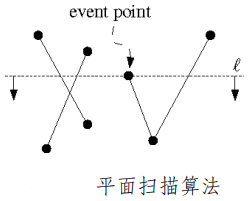

#### *三种事件点的处理*
**上端点**：当扫描线扫描到线段上端点时，进行出队操作，取出队顶元素，判断相邻线段与当前线段是否相交。相交时将交点入队，将其插入到按 y排序的队列中；\
**交点**：当扫描线扫描到交点$x_{ij}$时，将交点出队，并将T中交点对应的线段$s_{i},s_{j}$交换位置，再重新判断$s_{i},s_{j}$与各自的相邻线段是否相交，相交时，将新的交点插入按y值排序的队列中。\
**下端点**：当扫描线扫描到下端点时，将其出队，从T中将下端点对应的线段$s_{i}$删除，此时判断与$s_{i}$相邻的两个线段$S_{i}$是否相交，相交时，将其插入到按y排序的队列中。
###

### 2.1.算法实现

In [17]:
"""
——平面扫描算法实现文档——
"""
from Q import Q    # 事件队列Q，在文件Q.py中自定义
from T import T    # 扫描线状态结构T,在文件T.py中自定义
from helper import *   # 自定义模块
ev = 0.00000001
lower_check = 100

def getNextPoint(p, seg, y_lower):
	p1 = seg[0]
	p2 = seg[1]
	if (p1[0]-p2[0])==0:
		return (p[0]+10, p[1])
	slope = float(p1[1]-p2[1])/(p1[0]-p2[0])
	if slope==0:
		return (p1[0], p[1]-y_lower)
	y = p[1]-y_lower
	x = p1[0]-(p1[1]-y)/slope
	return (x, y)

def find_intersection(S):
    """
    输入：平面线段集S
    输出：S中各线段之间的所有交点（以及穿过各交点之间的线段的信息）
    """
    #初始化一个空的事件队列Q，将所有线段的上下端点插入Q，对于上端点还要记录其对应的线段
    s0 = S[0]
    if s0[1][1] > s0[0][1]:
        s0 = (s0[1], s0[0])
    q = Q(s0[0], [s0])
    q.insert(s0[1], [])
    intersections = {}   #交点为键，与交点关联的线段为值
    for s in S[1:]:
        if s[1][1] > s[0][1]:
            s = (s[1], s[0])
        q.insert(s[0], [s])
        q.insert(s[1], [])
    t = T()       #初始化一个空的状态结构T
    while q.key:    #当Q非空
        p, segs = q.get_and_del_min()  #找出下一事件点，将其删除
        handle_event_point(p, segs, q, t, intersections)   #处理事件点
    return intersections


def handle_event_point(p, segs, q, t, intersections):
    """
    U_p所有以p为上端点的线段构成的集合
    C_p所有包含p的线段构成的集合
    L_p:所有以p为下端点的线段构成的集合
    """
    rightmost = (float("-inf"), 0)
    rightmost_seg = None
    leftmost = (float("inf"), 0) 
    leftmost_seg = None

    U_p = segs               #得到U_p
    (C_p, L_p) = t.contain_p(p)     #在T中找出C_p,L_p
    merge_all = U_p+C_p+L_p
    if len(merge_all) > 1:        #U、C、L不止一条线段
        # 发现交点，同时返回线段
        intersections[p] = []     
        for s in merge_all:
            intersections[p].append(s) 
    merge_CL = C_p+L_p
    merge_UC = U_p+C_p
    
    # 将C和L的线段从T中删除
    for s in merge_CL:
        t.delete(p, s)
        
    # 将U和C的线段插入T
    for s in merge_UC:
        n = getNextPoint(p, s, lower_check) 
        if n[0] > rightmost[0]:
            rightmost = n 
            rightmost_seg = s
        if n[0] < leftmost[0]:
            leftmost = n
            leftmost_seg = s
        t.insert(p, s)

    if len(merge_UC) == 0:   # 如果U和C为空，
        neighbors = (t.get_left_neighbor(p), t.get_right_neighbor(p))       #在T中找出p的左右邻居
        if neighbors[0] and neighbors[1]:
            find_new_event(neighbors[0].value, neighbors[1].value, p, q)
    else:
        left_neighbor = t.get_left_neighbor(p)
        if left_neighbor:
            find_new_event(left_neighbor.value, leftmost_seg, p, q)  #找出U和C里最左边的线段leftmost_seg，找出紧邻于左侧的线段left_neighbor
        right_neighbor = t.get_right_neighbor(p)
        if right_neighbor:
            find_new_event(right_neighbor.value, rightmost_seg, p, q)

# 如果s1，s2相交于扫描线下方，将交点作为事件点插入Q中
def find_new_event(s1, s2, p, q):
    i = intersect(s1, s2)
    if i:
        if compare_by_y(i, p) == 1:
            if not q.find(i):
                q.insert(i, [])



END


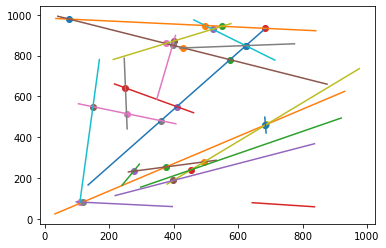

In [19]:
"""
——平面扫描算法测试文档———
点和线段用列表表示，例如：
点：[4,7]
线段：[[4,7],[1,3]
"""
from handle import find_intersection
from helper import *
import random
import matplotlib.pyplot as plt
N = 20             # 用于测试的线段的数量
MAX = 1000          # 生成线段的点的坐标最大值


def scale(i):
    return float(i)

S = []          # 线段集
for i in range(N):
    p1 = (scale(random.randint(0, MAX)), scale(random.randint(0, MAX)))
    p2 = (scale(random.randint(0, MAX)), scale(random.randint(0, MAX)))
    s = (p1, p2)
    plt.plot((p1[0], p2[0]),(p1[1], p2[1]))
    S.append(s)

inters = find_intersection(S).keys()    #    得到交点

for p in inters:
    plt.scatter(p[0],p[1])

print("END")
plt.show()